In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [7]:
DATA_FILE = "blackjack-rl.csv"

In [8]:
raw_df = pd.read_csv(DATA_FILE)

In [9]:
raw_df.head()

,Episode,Dealer,Current Hand,Num Hands,Hand,Has Ace,Can Split,Has Hit,Bet Size,Insurance,Action,Reward,Episode Net Reward
0,0,8,0,1,15,0,0,0,1,0.0,STAND,-1.0,-1.0
1,1,2,0,1,15,0,0,0,1,0.0,STAND,-1.0,-1.0
2,2,2,0,1,13,0,0,0,1,0.0,STAND,1.0,1.0
3,3,10,0,1,17,0,0,0,1,0.0,HIT,-1.0,-1.0
4,4,6,0,1,15,0,0,0,1,0.0,HIT,0.0,NaN


In [10]:
raw_df.shape

(180999, 13)

In [116]:
raw_df['Action'].unique()

array(['STAND', 'HIT', 'DOUBLE_DOWN', 'INSURANCE_HALF', 'INSURANCE_FULL',
       'SPLIT'], dtype=object)

In [143]:
def plot_rolling_rewards(df, window, title):
  plot_df = df[["Episode Net Reward"]].dropna().reset_index().rolling(window, step = window).mean()
  plt.plot(plot_df["Episode Net Reward"])
  plt.xlabel("Game")
  plt.ylabel("Profit")
  plt.title(title)

In [211]:
def plot_proportion_hands(df, hands_df, title):
  plot_df = df / hands_df
  plot_df.dropna().plot(kind='bar')
  plt.xlabel("Hand")
  plt.ylabel("Proportion of hands")
  plt.title(title)

## Training results

In [144]:
raw_df[["Episode Net Reward"]].dropna().mean()

Episode Net Reward   -0.106402
dtype: float64

In [145]:
raw_df[["Episode Net Reward"]].dropna().tail(10000).mean()

Episode Net Reward   -0.075825
dtype: float64

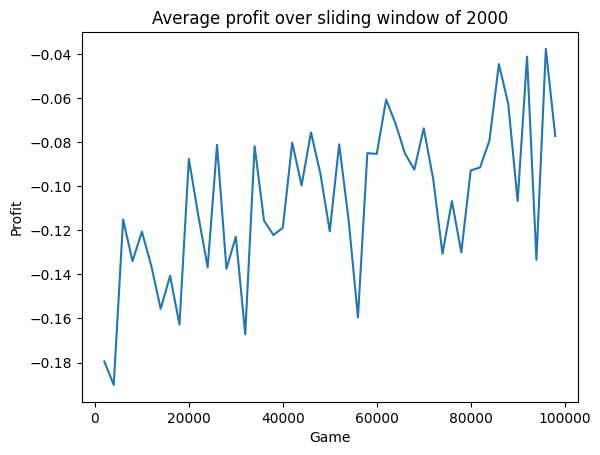

In [146]:
plot_rolling_rewards(raw_df, 2000, "Average profit over sliding window of 2000")

## Decisions investigation

In [205]:
# Create new columns for the max hand including ace
raw_df['Max Hand'] = np.where(raw_df['Hand'] + raw_df['Has Ace'] * 10 <= 21, raw_df['Hand'] + raw_df['Has Ace'] * 10, raw_df['Hand'])

In [256]:
# Create new dataframe for proportion of each hand
hands_df = raw_df['Hand'].value_counts()
max_hands_df = raw_df['Max Hand'].value_counts()

### Hit

In [219]:
hit_df = raw_df[raw_df["Action"] == "HIT"]

In [220]:
hit_df.head()

,Episode,Dealer,Current Hand,Num Hands,Hand,Has Ace,Can Split,Has Hit,Bet Size,Insurance,Action,Reward,Episode Net Reward,Max Hand
3,3,10,0,1,17,0,0,0,1,0.0,HIT,-1.0,-1.0,17
4,4,6,0,1,15,0,0,0,1,0.0,HIT,0.0,NaN,15
5,4,6,0,1,18,0,0,1,1,0.0,HIT,-1.0,-1.0,18
6,5,3,0,1,7,1,0,0,1,0.0,HIT,0.0,NaN,17
7,5,3,0,1,9,1,0,1,1,0.0,HIT,0.0,NaN,19


In [221]:
hit_df['Hand'].mean()

11.848197672976259

In [222]:
hit_df['Max Hand'].value_counts()

12    10252
14    10186
13    10031
15     9555
16     8051
11     5417
17     4983
10     4135
9      3902
8      2778
18     2536
7      2441
19     1840
6      1333
5      1200
20     1135
21      713
4       130
Name: Max Hand, dtype: int64

In [223]:
hit_df['Max Hand'].mean()

13.16142796893994

In [224]:
hit_df['Dealer'].mean()

7.125381428465107

In [225]:
smaller_hand_df = raw_df[raw_df['Hand'] <= raw_df['Dealer']]

In [226]:
smaller_hand_df[smaller_hand_df['Action'] == "HIT"].shape[0] / smaller_hand_df.shape[0]

0.8060860202867343

In [227]:
larger_hand_df = raw_df[raw_df['Max Hand'] > raw_df['Dealer']]

In [228]:
larger_hand_df[larger_hand_df['Action'] == "HIT"].shape[0] / larger_hand_df.shape[0]

0.4252155260113591

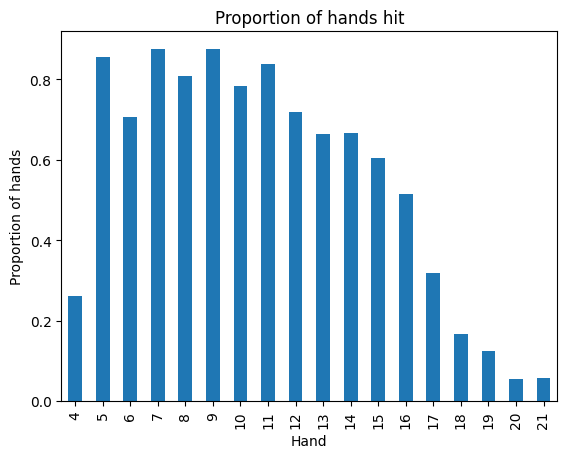

In [257]:
plot_proportion_hands(hit_df['Max Hand'].value_counts(), max_hands_df, "Proportion of hands hit")

### Stand

In [230]:
stand_df = raw_df[raw_df['Action'] == "STAND"]

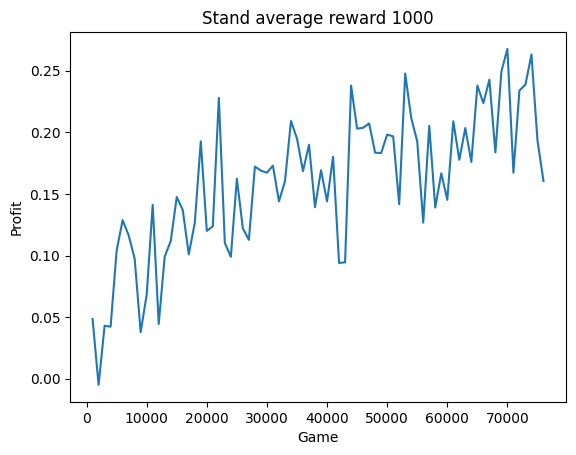

In [231]:
plot_rolling_rewards(stand_df, 1000, "Stand average reward 1000")

In [232]:
stand_df['Dealer'].mean()

6.304160498730308

In [233]:
stand_df['Hand'].mean()

16.3370762176409

In [234]:
stand_df['Max Hand'].mean()

17.53913179526062

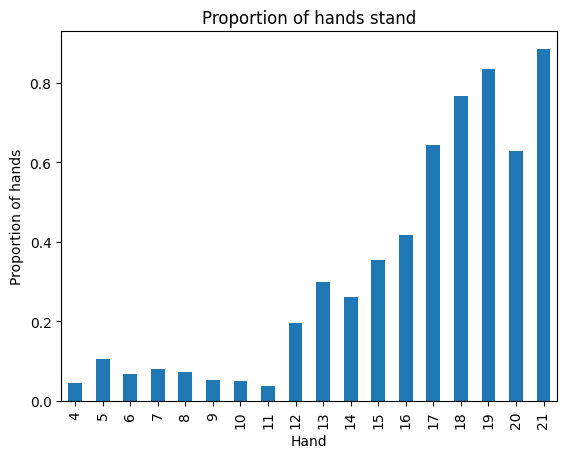

In [258]:
plot_proportion_hands(stand_df['Max Hand'].value_counts(), max_hands_df, "Proportion of hands stand")

### Double Down

In [236]:
double_df = raw_df[raw_df['Action'] == "DOUBLE_DOWN"]

In [237]:
double_df.shape

(1946, 14)

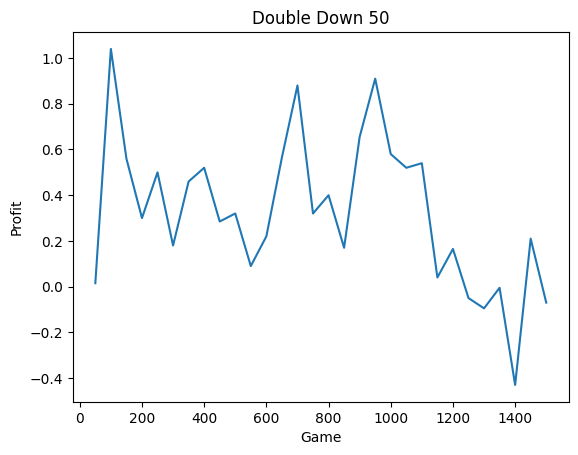

In [238]:
plot_rolling_rewards(double_df, 50, "Double Down 50")

In [239]:
double_df['Episode Net Reward'].mean()

0.3284789644012945

In [240]:
double_df['Hand'].mean()

10.40955806783145

In [241]:
double_df['Hand'].value_counts()

11    1144
10     455
9      347
Name: Hand, dtype: int64

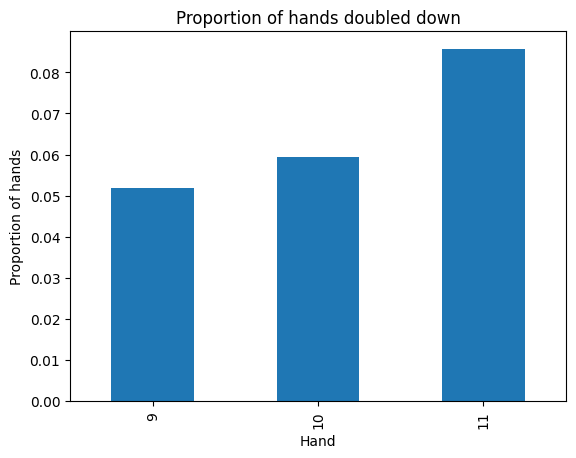

In [242]:
plot_proportion_hands(double_df['Hand'].value_counts(), hands_df, "Proportion of hands doubled down")

In [243]:
double_df['Max Hand'].mean()

14.433196300102775

In [244]:
double_df['Dealer'].mean()

5.596608427543679

###
Split

In [245]:
split_df = raw_df[raw_df['Action'] == "SPLIT"]

In [246]:
split_df.shape

(8925, 14)

In [247]:
split_df['Hand'].mean()

16.824425770308125

<Axes: >

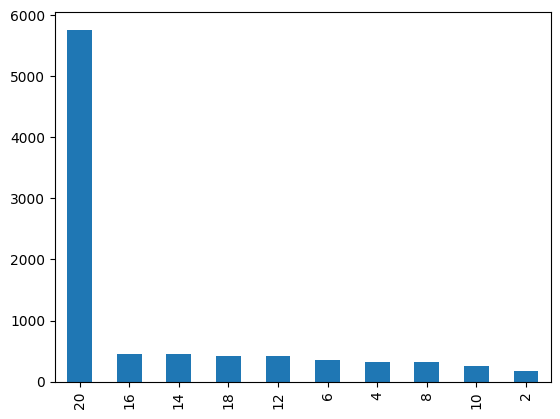

In [248]:
split_df['Hand'].value_counts().plot(kind='bar')

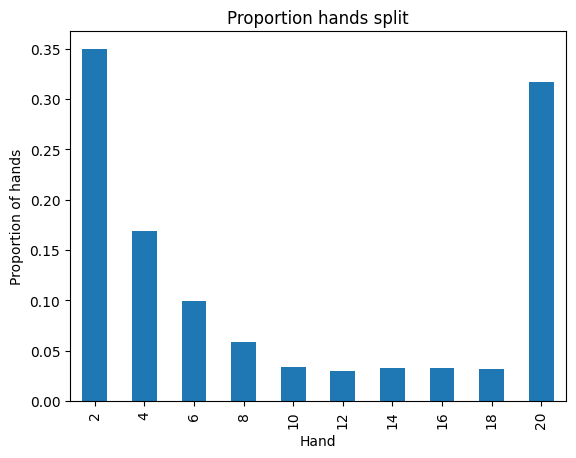

In [249]:
plot_proportion_hands(split_df['Hand'].value_counts(), hands_df, "Proportion hands split")

### Insurance

In [250]:
insurance_df = raw_df[(raw_df['Action'] == "INSURANCE_HALF") | (raw_df['Action'] == "INSURANCE_FULL")]

In [251]:
insurance_df['Dealer'].count() / raw_df[raw_df['Dealer'] == 1].shape[0]

0.3113299059074595

In [252]:
insurance_df['Max Hand'].mean()

15.02071973827699

<Axes: >

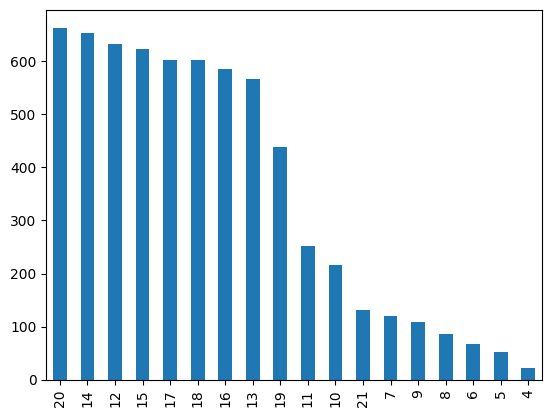

In [253]:
insurance_df['Max Hand'].value_counts().plot(kind='bar')

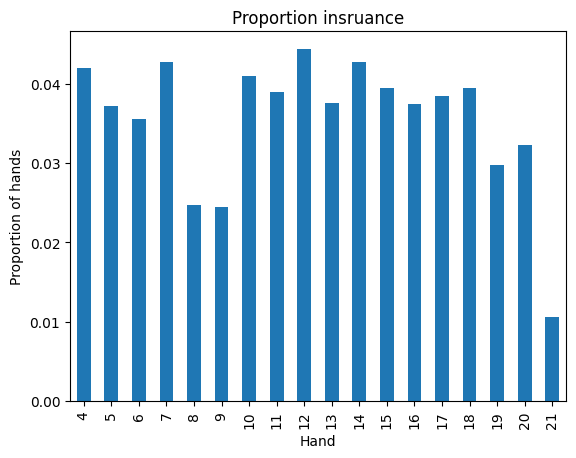

In [259]:
plot_proportion_hands(insurance_df['Max Hand'].value_counts(), max_hands_df, "Proportion insruance")